In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
%matplotlib inline
from collections import defaultdict

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from PIL import Image

/home/majid/applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
"""
Plotting some sample images
"""

'\nPlotting some sample images\n'

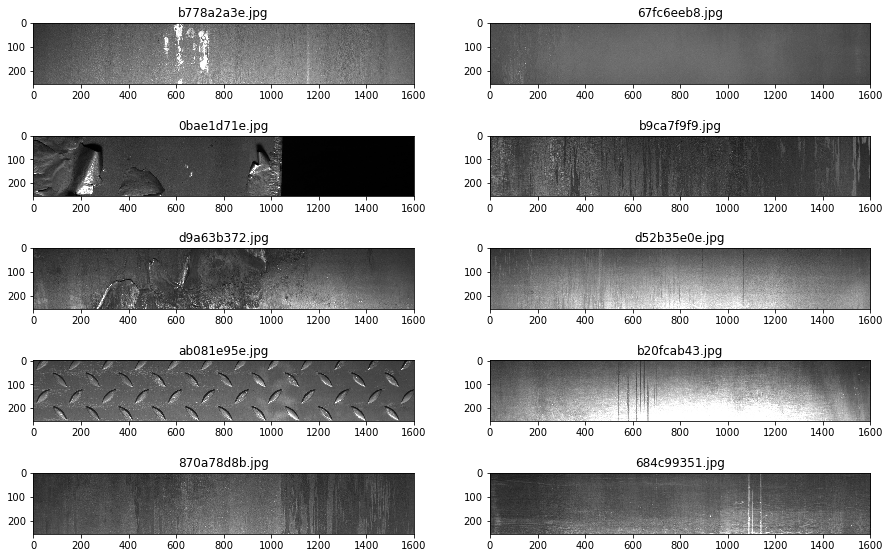

In [2]:
img_list = os.listdir('./train_image')
fig = plt.figure(figsize=(15,10))
fig.patch.set_facecolor('xkcd:white')
np.random.seed(42)
for (i, j) in zip(np.random.randint(0, len(img_list), size=10), range(10)) :
    img = plt.imread('./train_image/'+ img_list[i])
    a = fig.add_subplot(5, 2, j+1)
    plt.imshow(img)
    a.set_title(img_list[i])

In [ ]:
"""
Defects in sample images? Since there are 4 types of defects, we will seperate them. 
It makes sense to seperate these defects and train them seperately.
"""

In [3]:
train_pd = pd.read_csv('train.csv')
imageid = [t[:-2] for t in train_pd['ImageId_ClassId'].values]
classid = [int(t[-1:]) for t in train_pd['ImageId_ClassId'].values]
train_pd['ImageId'] = imageid
train_pd['ClassId'] = classid
train_pd.drop(columns='ImageId_ClassId', inplace=True)

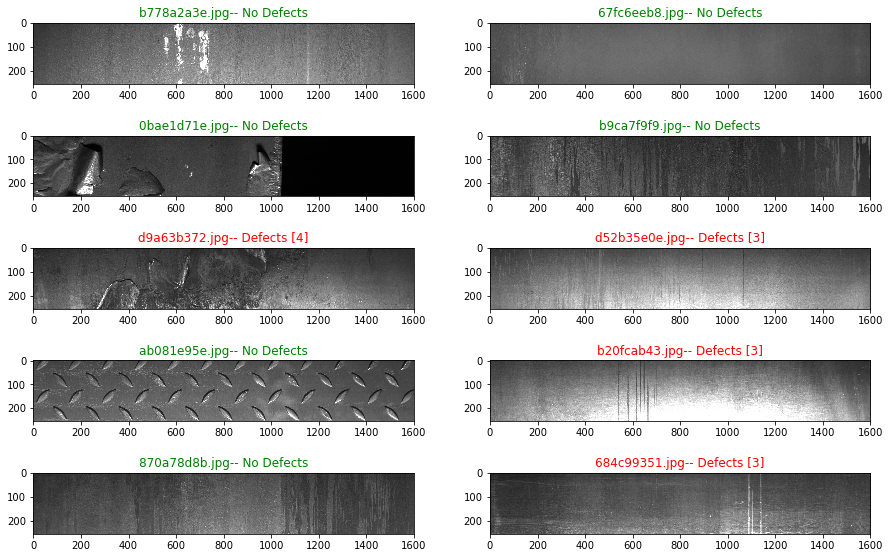

In [4]:
fig = plt.figure(figsize=(15,10))
fig.patch.set_facecolor('xkcd:white')
np.random.seed(42)
for (i, j) in zip(np.random.randint(0, len(img_list), size=10), range(10)) :
    img = plt.imread('./train_image/'+ img_list[i])
    a = fig.add_subplot(5, 2, j+1)
    plt.imshow(img)
    temp_ = train_pd.loc[train_pd['ImageId']==img_list[i]][['EncodedPixels', 'ClassId']].dropna()
    if temp_.shape[0]==0:
        a.set_title(img_list[i]+'-- No Defects', color='Green')
    else:
        defects = temp_['ClassId'].values
        a.set_title(img_list[i]+'-- Defects {}'.format(defects), color='Red')

In [7]:
"""
How many of each defects fo we have in the train set?
"""
temp_ = train_pd.dropna()
temp_.groupby('ClassId').count()

,EncodedPixels,ImageId
ClassId,,
1,897,897
2,247,247
3,5150,5150
4,801,801


In [8]:
"""
Image sizes: all the images for train and test set are same size. 
"""
from collections import defaultdict #enables to create key and values when it sees at first
train_size = defaultdict(int)
for img in train_pd['ImageId'].unique():
    temp_ = plt.imread('./train_image/'+ img)
    train_size[temp_.shape] += 1
print(train_size)

defaultdict(<class 'int'>, {(256, 1600, 3): 12568})


In [9]:
image_list = os.listdir('./test_image')
test_size = defaultdict(int)
for img in image_list:
    temp_ = plt.imread('./test_image/'+ img)
    test_size[temp_.shape] += 1
print(test_size)

defaultdict(<class 'int'>, {(256, 1600, 3): 1801})


In [5]:
mask_pd = train_pd.dropna()

In [8]:
"""
Making masks
"""
def make_mask(enc_pxl):
    enc_pxl_list = enc_pxl.split(' ')
    pxl = map(int, enc_pxl_list[0::2])
    lng = map(int, enc_pxl_list[1::2])
    mask = np.zeros(shape=256*1600)
    for p, l in zip(pxl, lng):
        mask[p-1:p+l-1] = 1
    return np.reshape(mask, [256,1600], order='F')

In [9]:
mask_pd['Mask'] = mask_pd['EncodedPixels'].apply(lambda x: make_mask(x))

/home/majid/applications/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [6]:
mask_pd.head()

,EncodedPixels,ImageId,ClassId,Mask
0,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0002cc93b.jpg,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
18,18661 28 18863 82 19091 110 19347 110 19603 11...,0007a71bf.jpg,3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
20,37607 3 37858 8 38108 14 38359 20 38610 25 388...,000a4bcdd.jpg,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
27,131973 1 132228 4 132483 6 132738 8 132993 11 ...,000f6bf48.jpg,4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
30,229501 11 229741 33 229981 55 230221 77 230468...,0014fce06.jpg,3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


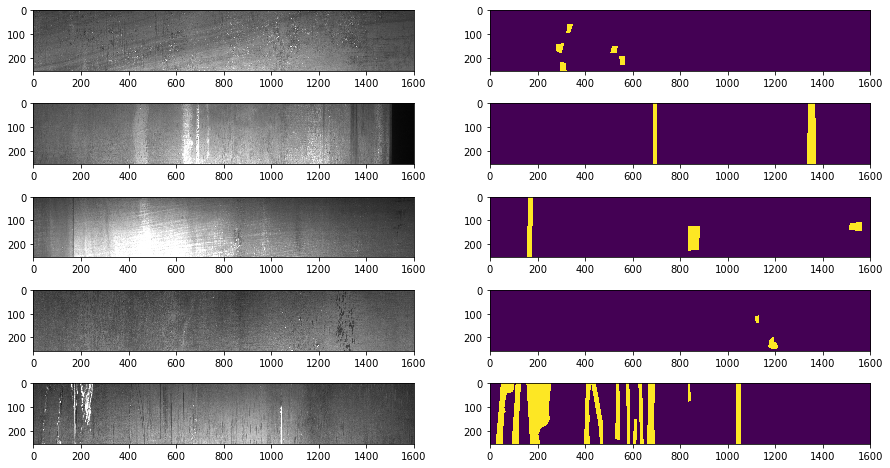

In [14]:
"""
Plotting some images with their defects
"""
fig = plt.figure(figsize=(15,10))
fig.patch.set_facecolor('xkcd:white')
np.random.seed(42)
for (i, j) in zip(np.random.randint(0, mask_pd.shape[0], size=5), range(5)) :
    img = plt.imread('./train_image/'+ mask_pd.iloc[i]['ImageId'])
    fig.add_subplot(6, 2, 2*j+1)
    plt.imshow(img)
    fig.add_subplot(6, 2, 2*j+2)
    plt.imshow(mask_pd.iloc[i]['Mask'])

In [16]:
"""
Let's first train a clasification network to whether an image has defect or not
"""

train_pd['Encoded'] = ~ train_pd['EncodedPixels'].isna()
train_pd_cls = train_pd.groupby(['ImageId']).aggregate({'Encoded': sum}).reset_index()
train_pd_cls['Encoded'] = (train_pd_cls['Encoded']>0).astype('int')
train_pd_cls.head()

,ImageId,Encoded
0,0002cc93b.jpg,1
1,00031f466.jpg,0
2,000418bfc.jpg,0
3,000789191.jpg,0
4,0007a71bf.jpg,1


In [8]:
"""
We will use Keras ImageDataGenerator to make some extra images with defects. 
LEt's first see what Keras ImageDataGenerator does
"""
def create_batch(imggen, image):
    
    image = np.reshape(image, (1,)+image.shape)
    fig = plt.figure(figsize=(15,10))
    fig.patch.set_facecolor('xkcd:white')
    a = fig.add_subplot(3, 3, 1)
    plt.imshow(image[0, :, :, :])
    i = 1
    for batch in imggen.flow(image, batch_size=1):
        i += 1
        a = fig.add_subplot(3, 3, i)
        plt.imshow(batch[0,:,:,:].astype('uint8'))
        if i > 8:
            break

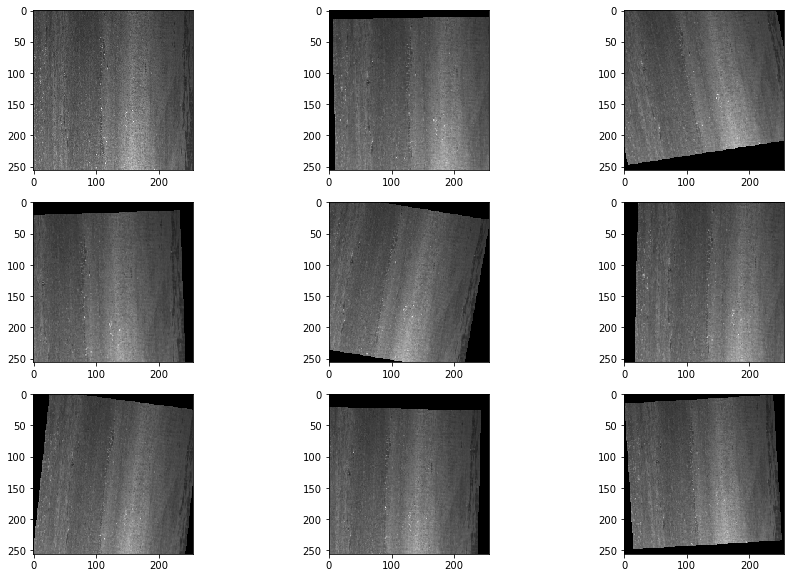

In [9]:
sample = './train_image/'+train_pd_cls.iloc[0, 0]
# img_plt = plt.imread(sample) #np array
img_pil = Image.open(sample)
sample = img_pil.resize((256, 256))
sample_np = np.array(sample.convert("RGB"))
imggen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
                            height_shift_range=0.1, zoom_range=0.1,
                           fill_mode='constant', cval=0)
batch = create_batch(imggen, sample_np)

In [21]:
"""
Modeling
"""
data_gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
                              height_shift_range=0.1, zoom_range=0.1, 
                              fill_mode='constant', cval=0.0, rescale=1/255, 
                              validation_split=0.15)

In [22]:
def create_data(datagen, subset):
    return datagen.flow_from_dataframe(train_pd_cls, directory='./train_image', 
                                       x_col='ImageId', y_col='Encoded', 
                                       target_size=(256, 256), class_mode='other', 
                                       batch_size=32, subset=subset)

In [23]:
train_gen = create_data(data_gen, 'training')
valid_gen = create_data(data_gen, 'validation')

Found 10683 images.
Found 1885 images.


In [24]:
test_pd_cls = pd.DataFrame(columns=['ImageId', 'Encoded'])
sample_sub = pd.read_csv("sample_submission.csv")
test_pd_cls['ImageId'] = sample_sub['ImageId_ClassId'].apply(lambda x: x[:-2]).unique()
test_pd_cls['Encoded'] = 0

In [25]:
data_gen_test = ImageDataGenerator(rescale=1/255)
test_gen = data_gen_test.flow_from_dataframe(test_pd_cls, directory='./test_image/', 
                                             x_col='ImageId', target_size=(256, 256), 
                                             class_mode=None, batch_size=32, shuffle=False)

Found 1801 images.


In [26]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.layers import *
from keras.applications.densenet import DenseNet121 as DN

In [31]:
def create_model(input_shape):
    
    model = Sequential()
    model.add(DN(include_top=False, 
                 input_shape=(input_shape[1], input_shape[2], input_shape[3]), 
                 weights='imagenet', pooling='avg'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [32]:
model = create_model((None,256,256,3))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 1024)              7037504   
_________________________________________________________________
batch_normalization_5 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_6 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 513       
Total para

In [33]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_acc', 
                             verbose = 1, save_best_only=True, 
                             save_weights_only=False,
                             mode='auto')
batch_size=32
total_steps = train_pd_cls.shape[0]/batch_size
history = model.fit_generator(train_gen, 
                              steps_per_epoch=total_steps * 0.85,
                              validation_data=valid_gen,
                              validation_steps=total_steps * 0.15,
                              epochs=8,
                              callbacks=[checkpoint])

Epoch 1/8
334/333 [==============================] - 8586s 26s/step - loss: 0.5643 - acc: 0.7452 - val_loss: 0.5984 - val_acc: 0.6944